In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.func1 = nn.RNNCell(self.input_size, self.hidden_size, nonlinearity='relu')
        self.func2 = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.func1(input, hidden)
        output = self.func2(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (func1): RNNCell(100, 100, nonlinearity=relu)
  (func2): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 12300  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
#################change optimizer ###############################
opt       = torch.optim.Adadelta(net.parameters(), lr=0.005) 
#################change optimizer ###############################
loss_func = nn.CrossEntropyLoss()

count = 0
# Training procedure.
for i in range(iters):
    try:
        input, target = get_input_and_target()            # Fetch input and target.
    except: 
        count += 1
        print("Illegal characters:")
        print(count)
        continue
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/12300 loss:4.612002849578857
1 c9/s\D]&$#@|"!X'~sipL~7WNVrAU%}K+a6+Z#N	oxGn5_]f(iXrs<8d
3[SM(Lbee5jWAt{S`]:?0Fc;AM~*>rl^/~2(

iter:199/12300 loss:4.593756675720215
generated sequence: W_XpU4_SaT1^|N<yALD_1}sqg?ZozICVpG 6D \$Gy`RhCJG_X'x,^P0{Pk~|B	$sUVu| fG"UG4Y!/Rq:-=8='VZ7!	A&GKaps

iter:299/12300 loss:4.5636773109436035
Sidc'.p	8iGHQU.[GDj_By#kX	4ADgr_0kGx)&;0.2yZ
<rTwaD)}

iter:399/12300 loss:4.1242170333862305
generated sequence: W|G,6qilhNerb?y#,n9mytCefcty laeuHIfhyhehelvsphta]w.p a .slhl
s.
plAt  slkusv7 F ell ah
s'daqphe lhd

iter:499/12300 loss:3.5871472358703613
generated sequence: WuU:;O9sHVu+bSp9|ggocmiAhnp lgdsd eae ohshAaapo:ftyhhhtSl a  piassh  al oy hh.  onpc,hethte llh e!tya

iter:599/12300 loss:3.4581613540649414
generated sequence: W0t?ip1'vO
t3 
aNa  erg
ss  ,!DcFrtGbGi IIk,st i
!sohdeoch uo  N na,!hl  a hyE,neillh!ee_.;eweoedtueo

iter:699/12300 loss:3.4201161861419678
generated sequence: WT'Rfd>MbKeosye{nuLteilB tirRf mN tehhgcn
/ rLppl ?oeHtefrfetge

#### Training Loss Curve

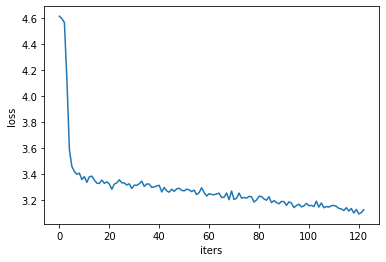

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

In [10]:
all_losses

[tensor(4.6120, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5938, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.5637, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(4.1242, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.5871, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4582, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4201, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3988, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.4074, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3583, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3803, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3373, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3791, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3843, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3543, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3309, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3280, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(3.3546

#### Evaluation: A Sample of Generated Sequence

In [11]:
print(eval_step(net, predicted_len=600))

W1o.t,t,w s
lsthlnn ashemettms a
aluigyg,herdnotxm OohtsN,oed uuorroi meR thg ske t rnt so t b  Tfse  oleSaeSe,
rg  .hn, loana weeIwhaa inanrfkrpdbcTIit st, Laehg Uhiae thd Ghe lnelma ,tate
o sgs K-iA
mIy b?noe fhae eash 
hint oknios uel Ioe s MSl ttWl -w d
a,SAhdss 'n nt:sea.f St:thrhrheal
tpo
:-gno Ah rh ocs ni
diy:
ltmtBpare:t tdem d   
s oeeoro rhahor le:tot  e otsta ia 
sratMnGRyi,es stn;' iiwedpeaokhhIs-rooh 
Se, l,nfu Doer   hktsgamrw,d,kFb seito ,y ae i Ii. aorYenoeTdnalatoceth
 rlofOw li esfcI As iro saw ipr ur 
et,il;bnd  rombra.nyens k ul l.ay
t
tde,dP,lalnauUdcoootefies,tI oyhe:
 cu


In [12]:
import numpy as np
f = open("original_RNN.npy", "w")

In [13]:
a = [data.item() for data in all_losses]

In [14]:
a

[4.612002849578857,
 4.593756675720215,
 4.5636773109436035,
 4.1242170333862305,
 3.5871472358703613,
 3.4581613540649414,
 3.4201161861419678,
 3.398777961730957,
 3.407365322113037,
 3.358309030532837,
 3.380276679992676,
 3.337256908416748,
 3.3791074752807617,
 3.384340524673462,
 3.3542513847351074,
 3.3308613300323486,
 3.328003406524658,
 3.354647159576416,
 3.329019784927368,
 3.3407232761383057,
 3.324009656906128,
 3.283921718597412,
 3.3230628967285156,
 3.3331573009490967,
 3.35642409324646,
 3.3335444927215576,
 3.332045316696167,
 3.316032648086548,
 3.326037883758545,
 3.28916597366333,
 3.3156073093414307,
 3.313764810562134,
 3.3257079124450684,
 3.3459537029266357,
 3.3057186603546143,
 3.3245370388031006,
 3.3233118057250977,
 3.2982101440429688,
 3.301628351211548,
 3.3090224266052246,
 3.314007520675659,
 3.263212203979492,
 3.297388792037964,
 3.2716684341430664,
 3.261237621307373,
 3.284172296524048,
 3.267744779586792,
 3.28696346282959,
 3.291425943374634,
 3

In [15]:
np.save("original_RNN.npy", a)

In [16]:
np.load("original_RNN.npy")

array([4.61200285, 4.59375668, 4.56367731, 4.12421703, 3.58714724,
       3.45816135, 3.42011619, 3.39877796, 3.40736532, 3.35830903,
       3.38027668, 3.33725691, 3.37910748, 3.38434052, 3.35425138,
       3.33086133, 3.32800341, 3.35464716, 3.32901978, 3.34072328,
       3.32400966, 3.28392172, 3.3230629 , 3.3331573 , 3.35642409,
       3.33354449, 3.33204532, 3.31603265, 3.32603788, 3.28916597,
       3.31560731, 3.31376481, 3.32570791, 3.3459537 , 3.30571866,
       3.32453704, 3.32331181, 3.29821014, 3.30162835, 3.30902243,
       3.31400752, 3.2632122 , 3.29738879, 3.27166843, 3.26123762,
       3.2841723 , 3.26774478, 3.28696346, 3.29142594, 3.27554679,
       3.27096605, 3.28477621, 3.27868438, 3.26572084, 3.27745271,
       3.2428484 , 3.25829268, 3.29502201, 3.25837398, 3.23167205,
       3.24996305, 3.24367952, 3.24175906, 3.24747586, 3.25376368,
       3.22066021, 3.22269273, 3.25494504, 3.20361233, 3.27011681,
       3.20558858, 3.21503663, 3.25474715, 3.2159605 , 3.22042

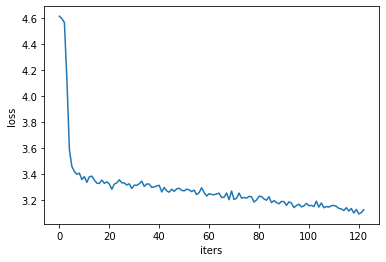

In [17]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("original_RNN.npy"), label = "graph")
plt.show()

In [18]:
## experiment different plotting

In [19]:
import numpy as np
import matplotlib.pyplot as plt
a = np.random.choice(100, 100)
b = np.random.choice(100, 100)
y = np.arange(100) #length of the loss

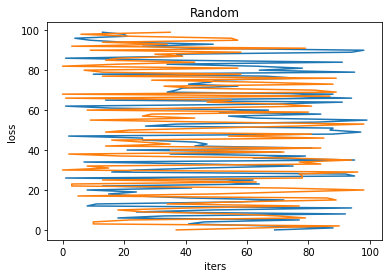

In [20]:
plt.xlabel('iters')
plt.ylabel('loss')
p1 = plt.plot(a, y, label="First Line")
p2 = plt.plot(b, y, label='Second Line')
plt.title('Random')
plt.plot(labels = ['Men', 'Women'])
plt.show()

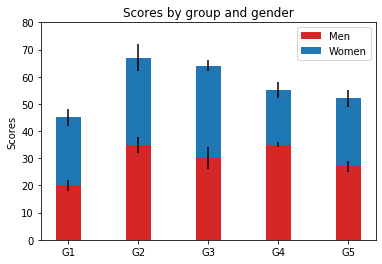

In [21]:
import numpy as np
import matplotlib.pyplot as plt


N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width, color='#d62728', yerr=menStd)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans, yerr=womenStd)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()
